## Exc day 7

In [198]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

In [199]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_house = fetch_california_housing()    
X = pd.DataFrame(data=cal_house['data'], 
                 columns=cal_house['feature_names'])\
             .iloc[:,:-2]
y = cal_house['target']

In [201]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline

perform_val = []
perform_test = []
for i in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=2/3, random_state=i)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=.5, random_state=i)
    pipe_lin = make_pipeline(LinearRegression())
    pipe_lin.fit(X_train, y_train)
    perform_val.append(mse(pipe_lin.predict(X_val), y_val))
    perform_test.append(mse(pipe_lin.predict(X_test), y_test))

rmse = pd.DataFrame([perform_val, perform_test])
rmse

,0,1,2,3,4,5,6,7,8,9
0,4.674733,4.281578,0.600226,0.567047,10.678656,1.407859,0.610142,1.983330,0.673593,0.635999
1,6.007534,2.937226,0.631442,6.172984,13.883766,8.991859,0.654161,1.500409,0.972118,0.616642


In [202]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
pipe_lasso = make_pipeline(PolynomialFeatures(degree = 3, include_bias=False),
                          StandardScaler(),
                          Lasso())
pipe_lasso.fit(X_train, y_train)
perform_val_lasso = mse(pipe_lasso.predict(X_val), y_val)
perform_test_lasso = mse(pipe_lasso.predict(X_test), y_test)
print(perform_val_lasso, perform_test_lasso)

1.3827465964520191 1.3216842228076797


In [203]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=5)
mseCV = []
lambdas =  np.logspace(-4, 4, 12)

for lambda_ in lambdas:
    
    pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False),
                          StandardScaler(),
                          Lasso(alpha=lambda_, random_state=1))
    mseCV_ = []
        
    for tidx, validx in kfolds.split(X_dev, y_dev):
            
        X_train, y_train = X_dev.iloc[tidx], y_dev[tidx]
        X_val, y_val = X_dev.iloc[validx], y_dev[validx]
            
        pipe_lassoCV.fit(X_train, y_train)
            
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))
    mseCV.append(mseCV_)

optimalCV = pd.DataFrame(mseCV, index=lambdas).mean(axis=1).nsmallest(1)
optimalCV

0.081113    0.770981
dtype: float64

In [204]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',
                     cv=5)

mse_ = pd.DataFrame({'Train': -train_scores.mean(axis=1),'Test': -test_scores.mean(axis=1), 'lambda': lambdas}).set_index('lambda')
print(mse_.Test.nsmallest(1))

lambda
0.081113    0.663315
Name: Test, dtype: float64


## Set 14

In [8]:
rawdata = sns.load_dataset('titanic').sample(frac=1, random_state = 3)
rawdata['male'] = (rawdata['sex'] == 'male').astype(int)
rawdata['alone'] = rawdata['alone'].astype(int)
rawdata['adult_male'] = rawdata['adult_male'].astype(int)
data = pd.get_dummies(rawdata, 
                      columns = ['class', 'sibsp', 'parch', 'deck'], 
                      drop_first=True)\
         .drop(['pclass', 'sex', 'embarked', 'who', 'embark_town', 'alive'], axis = 1)
data.head()

,survived,age,fare,adult_male,alone,male,class_Second,class_Third,sibsp_1,sibsp_2,...,parch_3,parch_4,parch_5,parch_6,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G
395,0,22.0,7.7958,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
85,1,33.0,15.8500,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
201,0,NaN,69.5500,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
542,0,11.0,31.2750,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
702,0,18.0,14.4542,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
data = data.dropna()
X = np.array(data.drop('survived', axis=1))
y = np.array(data.survived)

In [210]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
dectree = model.fit(X, y)  # <--- This is the training/fitting/learning step

In [211]:
y_hat = dectree.predict(X)

def perf_measure(y, y_hat):
    TP = 0
    FN = 0
    TN = 0
    FP = 0
    for i in range(len(y)): 
        if y[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y[i]!=y_hat[i]:
           FN += 1
        if y[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y[i]!=y_hat[i]:
           FP += 1
        
    return(TP, FN, TN, FP)

print(sum(perf_measure(y, y_hat)))
print(len(y))

714
714


In [212]:
def acc_function(y, y_hat):
    out = perf_measure(y, y_hat)
    return (out[0] + out[2])/(out[0] + out[1] + out[2] + out[3])

acc_function(y, y_hat)

0.9901960784313726

In [213]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=1)

In [214]:
dectree_train = model.fit(X_train, y_train)
y_hat_test = dectree_train.predict(X_test)
acc_function(y_test, y_hat_test)

0.742296918767507

In [215]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
rf_train = rf.fit(X_train, y_train)
y_hat_test_rf = rf_train.predict(X_test)
acc_function(y_test, y_hat_test_rf)

0.8067226890756303

In [235]:
from sklearn.model_selection import validation_curve
estimators = range(1, 100, 5)

train_scores, test_scores = \
    validation_curve(estimator=RandomForestClassifier(n_estimators=10,random_state=2),
                     X=X_train,
                     y=y_train,
                     param_name='n_estimators',
                     param_range=estimators,
                     scoring='accuracy',
                     cv=5)

scores_est = pd.DataFrame({'Train': -train_scores.mean(axis=1),'Test': -test_scores.mean(axis=1), 'n_estimators': estimators})
scores_est

,Train,Test,n_estimators
0,-0.873944,-0.717293,1
1,-0.964986,-0.750743,6
2,-0.983894,-0.742410,11
3,-0.988097,-0.770423,16
4,-0.988809,-0.736698,21
5,-0.990207,-0.750704,26
6,-0.991603,-0.745110,31
7,-0.993706,-0.756221,36
8,-0.993704,-0.745110,41
9,-0.994403,-0.747887,46


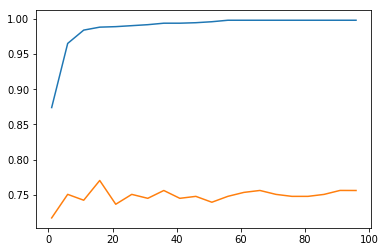

In [238]:
f,ax = plt.subplots()

ax.plot(estimators, np.mean(train_scores, 1), label='Test scores')
ax.plot(estimators, np.mean(test_scores, 1), label='Train scores')

Text(0,0.5,'Number of observations used')

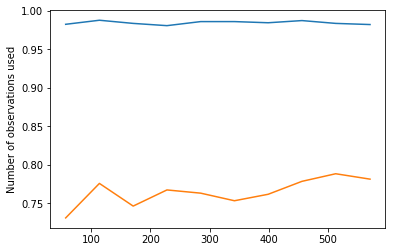

In [227]:
from sklearn.model_selection import learning_curve
l_ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=RandomForestClassifier(n_estimators=20), 
                   train_sizes=l_ts,
                   X=X, 
                   y=y,
                   cv=5)

f,ax = plt.subplots()
ax.plot(train_sizes, np.mean(train_scores, 1), label='Test scores')
ax.plot(train_sizes, np.mean(test_scores, 1), label='Train scores')    
ax.set_ylabel('Accuracy')
ax.set_ylabel('Number of observations used')